<a href="https://colab.research.google.com/github/JinkyoHan/JinkyoHan/blob/NAS-SR/EF_Designer_0_3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E.F Designer**
> **ver 0.3.8**
---
> Written by **Jinkyo Han**, OST, SNU NAOE
> * 38jinkyo@snu.ac.kr
> Supervised by **Do Kyun Kim**, OST, SNU NAOE


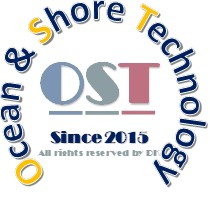

* # contact OST [here](https://ost.snu.ac.kr/home)


¬ Copyright (c) 2023 Jinkyo Han

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

# Chapter.0 Introduction

---

# Here are 4 main tasks herein

1.   Generate nondimensionalized parameters from you dataset.
> * during (1), task (2) could be applied

2.   By random forest regression: select a few nondimensionalized parameters, which can most greatly represent the dataset.
3.   Using NAS algorithm, generate the most-fitted & simple MLP model, **"SumNET"** (=MLP+MLP)
> * During searching by NAS, NuSVR would estimate the model's performance, which described by Baker et al., 2017.
> * visit [here](https://colab.research.google.com/github/JinkyoHan/JinkyoHan/blob/main/ann_designer_basic_1_0_0.ipynb) for NAS tutorials
4.   By Symbolic Regression, based on GP method: automatically generate empirical formula, using PySR package by Cranmer et al., 2023.(which achieved the best score within *EmpiricalBench*)

# **[Reference]**

> [NAS]

https://arxiv.org/abs/1808.05377

https://arxiv.org/abs/1705.10823

> [PySR]

https://arxiv.org/pdf/2305.01582.pdf

https://arxiv.org/abs/2006.11287

https://github.com/MilesCranmer/PySR

---

# Chapter.1 Nondim' Parameters

---

# 1. Install Julia

---

logo.svg

Julia is a new-born computational data science language, developed at 2012.

PySR will fluently help you out with executing Julia at back-end, so no worries.

Within Colab, order below would automatically install Julia.

If you want to execute PySR at *VS Code* environment, please visit [here](https://julialang.org/downloads/)

In [1]:
!sudo apt update -y
!sudo apt upgrade -y
!sudo apt install wget -y
!wget https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz
!tar -xvzf julia-1.9.3-linux-x86_64.tar.gz
!sudo cp -r julia-1.9.3 /opt/
!sudo ln -s /opt/julia-1.9.3/bin/julia /usr/local/bin/julia

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [962 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,079 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,059 kB]
Get:13 http://archive.ubun

# 2. Install PySR

---

PySR is an useful tool, providing the most extensive authority

for symbolic regression users, between pip-installable packages..


공개된 기호적 회귀 패키지 중 가장 높은 자유도를 지닙니다.

PySR need to be installed only once, **the very first time** you try this code.

In [2]:
!pip install julia
!pip install pysr pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 54.1 MB/s eta 0:00:00


In [3]:
import os
os.environ["PATH"] += ":/usr/local/bin/julia"

In [4]:
import pysr

# We don't precompile in colab because compiled modules
# are incompatible static Python libraries:
pysr.install()


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:118: UserWarning: It is recommended to restart Python after installing PySR's dependencies, so that the Julia environment is properly initialized.
  warnings.warn(


# 3. Import basics

---

Some packages need to be imported,,,

In [5]:
import sympy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# 4. Mount Google Drive & Read Dataset

---

By mounting google drive, you can easily back-up your each processes.

Caution: This code is very fragile. Please be patient.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# where is your dataset
# file_path = '/content/drive/MyDrive/MyInput.xlsx'  # should be modified into your path

file_path = 'MyInput.xlsx'  # should be modified into your path


# read dataset
data = pd.read_excel(file_path)

# 5. Split dataset into Input&Output

---

This code assumes that your dataset has the same unit for the input data,

and un-nondimensionalized output data.

You can easily modify the code, from now on.

In [7]:
# Read Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from itertools import combinations
#-----------------------------------------------------------

data = data.dropna()

# Assuming the last column in your dataset is the target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]/315 # y value nondim'ed herein.

print(X)
print(y)

         TP   BF    TW  TF    HW
0      44.5  100  10.0  14   200
1      44.5  100  10.0  14   284
2      44.5  100  10.0  14   300
3      44.5  100  10.0  14   360
4      44.5  100  10.0  14   425
...     ...  ...   ...  ..   ...
10493   9.5  200  28.0  30   500
10494   9.5  200  28.0  30   460
10495   9.5  200  28.0  30   700
10496   9.5  200  28.0  30   800
10497   9.5  200  28.0  30  1000

[10498 rows x 5 columns]
0        0.553074
1        0.705244
2        0.719511
3        0.751525
4        0.816629
           ...   
10493    0.793881
10494    0.813152
10495    0.705881
10496    0.655486
10497    0.585506
Name: ULS, Length: 10498, dtype: float64


# 6. generate nondimensionalized parameters

---

Implemented methods: ***Buckingham's Pi Theorem***

i) define "powers"

ii) generate combinations for "powers"

iii) for sum(power)==0: generate nondimensionalized


During each generation of nondim' parameters, its feature importance would be evaluated by RandomForestRegressor;

thus only ***top_n*** of parameters would be remained.


# **CAUTION: Don't Execute this cell more than once.**

cell above must be executed previously.

In [ ]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def create_dimensionless_parameters(df, y, drop_origin=True, top_n=6):
    powers = [-1, -1/2, 0, 1/2, 1, 2] # you can modify here as your needs
    columns = df.columns
    result = pd.DataFrame()

    # generate combinations of 'power', for you nondim' parameters.
    combinations = itertools.product(powers, repeat=len(columns))
    iters = 0

    for idx, combo in enumerate(combinations):
        if sum(combo) == 0:  # for 'sum to zeros' only
            # Update naming convention
            new_col_name = '_'.join([f"{col}_p{str(p).replace('-', 'n').replace('.', 'd')}" for col, p in zip(columns, combo)])
            temp_result = df.apply(lambda row: prod_with_power(row, combo), axis=1)
            result = result.copy()
            result.loc[:, new_col_name] = temp_result

            # between each iterations,
            combined_df = pd.concat([df, result], axis=1)
            if drop_origin:
                training_df = combined_df.drop(columns=columns)
            else:
                training_df = combined_df

            model = RandomForestRegressor(n_estimators=30)
            model.fit(training_df, y)
            feature_importances = model.feature_importances_

            # maintain only (top_n) features
            important_indices = feature_importances.argsort()[-top_n:][::-1]
            important_features = training_df.columns[important_indices]

            # print procedures
            print(f"Iteration {iters+1}")
            print(f"Important features: {important_features.tolist()}")

            result = combined_df[important_features]

    return result


def prod_with_power(row, powers):
    result = 1
    for value, power in zip(row, powers):
        result *= value**power
    return result

# Figure out the most important nondim' features
X = create_dimensionless_parameters(X, y, drop_origin=True, top_n=10)
X.to_csv('top_n_features.csv', index=False)
print(X)


# 7. RandomForestRegressor would pick out some number of best nondim' parameters for your dataset.

---

**Caution:** Random Forest Regression is alreay defined inside the *PySR*.

Yet to print out, exclusive package of sklearn would be applied herein.

Moreover, selected features by Random Forest Regression may *not represent the optimal* features for your training.

However, such sets would be suboptimal, at least.

Thus herein, you could define 'N', which will figure out the most important *N* features, among *top_n* features.

Good Luck!

In [8]:
X = pd.read_csv('top_n_features.csv')

# Initialize and fit the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X, y)

# get feature importances
feature_importances = regressor.feature_importances_

# print it out
for feature, importance in zip(X.columns, feature_importances):
    print(f'Feature: {feature}, Importance: {importance}')

# pick out the best 'N' parameters, with score.
N = 6
top_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)[:N]
print(f'Top {N} important features:')
for feature, importance in top_features:
    print(f'Feature: {feature}, Importance: {importance}')

Feature: TPp2_BFp0_TWp0d5_TFpn0d5_HWpn2, Importance: 0.36912851238814387
Feature: TPp3_BFpn1_TWp0_TFpn1_HWpn1, Importance: 0.12064485320510256
Feature: TPpn2_BFp0_TWpn0d5_TFp0d5_HWp2, Importance: 0.1505048779038222
Feature: TPpn2_BFp0_TWpn1_TFp0_HWp3, Importance: 0.09483178764841392
Feature: TPpn1_BFp0_TWp0_TFp0d5_HWp0d5, Importance: 0.024535590101506948
Feature: TPp3_BFp0_TWp0_TFpn2_HWpn1, Importance: 0.028325841115249027
Feature: TPpn0d5_BFpn0d5_TWpn1_TFp0_HWp2, Importance: 0.0276508753043265
Feature: TPpn1_BFp0_TWp0_TFp0_HWp1, Importance: 0.023814345185042402
Feature: TPp0_BFpn1_TWp3_TFpn1_HWpn1, Importance: 0.020036394596694686
Feature: TPp0d5_BFpn1_TWpn0d5_TFpn1_HWp2, Importance: 0.017425387465979648
Feature: TPp0d5_BFp0_TWp0_TFp0_HWpn0d5, Importance: 0.015523521158666263
Feature: TPp3_BFp0_TWpn2_TFp0_HWpn1, Importance: 0.01617332391642722
Feature: TPp2_BFpn2_TWp0_TFp0_HWp0, Importance: 0.01689229969599252
Feature: TPp1_BFp0_TWp0_TFp0_HWpn1, Importance: 0.015266930217747207
Featur

# 8. Show the best parameter set

---

Meanwhile, there could be NaN values, somehow.

Drop NaN values here.

In [9]:
# Best Parameter Set for YOU

selected_features = [feature for feature, _ in top_features]
X_selected = X[selected_features]

# find out rows with NaN values
drop_indices = X_selected.dropna().index

# drop NaN
X_selected = X_selected.loc[drop_indices]
y = y.loc[drop_indices]

print(X_selected)
print(y)

       TPp2_BFp0_TWp0d5_TFpn0d5_HWpn2  TPpn2_BFp0_TWpn0d5_TFp0d5_HWp2  \
0                            0.041840                       23.900335   
1                            0.020750                       48.192635   
2                            0.018596                       53.775754   
3                            0.012914                       77.437085   
4                            0.009266                      107.924950   
...                               ...                             ...   
10493                        0.000349                     2867.308418   
10494                        0.000412                     2426.889845   
10495                        0.000178                     5619.924500   
10496                        0.000136                     7340.309551   
10497                        0.000087                    11469.233673   

       TPp3_BFpn1_TWp0_TFpn1_HWpn1  TPpn2_BFp0_TWpn1_TFp0_HWp3  \
0                         0.314718                  403.9

---

# Chapter.2 Generate model by NAS

---

# 1. Import Tensorflow

---

Basic Requirments would be fulfilled herein.

In [10]:
!pip install tensorflow
!pip install scikit-optimize

# Import Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import json
#-----------------------------------------------------------
# Add the required libraries for Bayesian optimization
import skopt
    # Caution : please open your scikit-optimize package,
    # and then replace every 'np.int' into 'int', in 'transformer.py'
    # Anaconda\Lib\site-packages\skopt\space\transformers.py
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
#-----------------------------------------------------------

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.7 MB/s eta 0:00:00


# 2. Engage your GPU

---

In [11]:
# Does GPU Works?
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
#-----------------------------------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device_lib.list_local_devices())
#-----------------------------------------------------------

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1091014522144463102
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40161050624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14213526378031958282
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


# 3. Split Data

---

In [23]:
# Read Data
from sklearn.model_selection import train_test_split
#-----------------------------------------------------------
X_clean = X_selected.values
y_clean = y.values

X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=7)

# Reshaping data
input_data_train = [X_train[:, i].reshape(-1, 1) for i in range(X_train.shape[1])]
input_data_val = [X_val[:, i].reshape(-1, 1) for i in range(X_val.shape[1])]

print(X_train, y_train)
print(X_val, y_val)
#-----------------------------------------------------------

[[2.51773715e-02 3.97182049e+01 3.90092330e-02 3.78698225e+02
  3.54629390e-01 2.48069469e+01]
 [3.86392688e-03 2.58804069e+02 1.59064901e-02 4.95539297e+03
  7.23022276e-02 1.73947203e+02]
 [5.04413749e-03 1.98249949e+02 1.12679989e-02 3.60472842e+03
  1.40849986e-01 7.54585952e+01]
 ...
 [2.68249714e-03 3.72786977e+02 5.15090543e-03 8.94777500e+03
  7.35843633e-02 1.42581011e+02]
 [2.95014733e-03 3.38966122e+02 4.00550568e-02 1.29276606e+04
  2.27585550e-01 4.29056975e+02]
 [4.28449753e-04 2.33399598e+03 9.49342561e-04 6.80470914e+04
  6.98046000e-03 4.19325273e+02]] [0.86033048 0.81743365 0.92112127 ... 0.76684381 0.88360667 0.67025587]
[[5.34785694e-04 1.86990791e+03 1.32560386e-03 4.96612245e+04
  6.62801932e-03 4.61749056e+02]
 [6.05415405e-05 1.65175843e+04 1.42895833e-04 8.20765364e+05
  9.52638889e-04 1.69937581e+03]
 [1.92093675e-03 5.20579347e+02 2.88471639e-02 2.40543502e+04
  1.69689199e-01 6.36679155e+02]
 ...
 [1.10895826e-02 9.01747192e+01 6.53869048e-02 2.04497041e+03


# 4. Definitions by TensorFlow

---

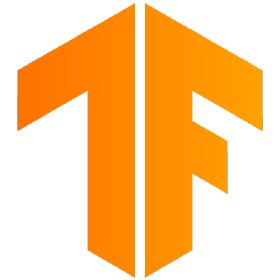

a) Early Stopping

b) Create Model = (N, 1) + (1, 1)

In [45]:
# Generate earlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
#-----------------------------------------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
#-----------------------------------------------------------


# Function : Create SumNET
#-----------------------------------------------------------
class SumNet:
    def __init__(self, layer_nodes, learning_rate, activation, dropout_rate, optimizer, loss_function):
        self.model_g = self.create_sumnet_g(layer_nodes, activation, dropout_rate)
        self.model_f = self.create_sumnet_f(layer_nodes, activation, dropout_rate)
        self.model = self.build_model(layer_nodes, learning_rate, activation, dropout_rate, optimizer, loss_function)

    def create_sumnet_g(self, layer_nodes, activation, dropout_rate):
        model_g_inputs = [tf.keras.layers.Input(shape=(1,)) for _ in range(N)]
        x = tf.keras.layers.Concatenate()(model_g_inputs)

        for nodes in layer_nodes:
            x = tf.keras.layers.Dense(nodes, activation=activation)(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        model_g_output = tf.keras.layers.Dense(1)(x)
        return tf.keras.Model(inputs=model_g_inputs, outputs=model_g_output)

    def create_sumnet_f(self, layer_nodes, activation, dropout_rate):
        model_f_input = tf.keras.layers.Input(shape=(1,))
        x = model_f_input

        for nodes in layer_nodes:
            x = tf.keras.layers.Dense(nodes, activation=activation)(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        model_f_output = tf.keras.layers.Dense(1)(x)
        return tf.keras.Model(inputs=model_f_input, outputs=model_f_output)

    def build_model(self, layer_nodes, learning_rate, activation, dropout_rate, optimizer, loss_function):
        inputs = [tf.keras.layers.Input(shape=(1,)) for _ in range(N)]
        g_out = self.model_g(inputs)
        f_out = self.model_f(g_out)
        outputs = f_out

        sumnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

        opt = None
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        sumnet_model.compile(optimizer=opt, loss=loss_function, metrics=['mse'])
        return sumnet_model

#-----------------------------------------------------------

# Function: show plot
#-----------------------------------------------------------
def show_plot(params, val_mse, epoch_rate, predicted_performance, toshow=False):
    if toshow==True:
        plt.plot(np.arange(int(params['epochs']*epoch_rate)), val_mse, label='Actual')
        plt.axhline(y=predicted_performance, color='r', linestyle='dashed', label='Predicted')
        plt.xlabel('Epoch')
        plt.ylabel('Validation MSE')
        plt.legend()
        plt.show()
#-----------------------------------------------------------

Search space could be defined by your own here.

Recommended Options:

*   Activation Function - ReLu

*   Optimizer - Adam

In [47]:
# Define the search space
#-----------------------------------------------------------
    # Define the hyperparameter search space
    # Caution: this
max_layers = 2
layer_nodes_space = [Integer(64, 256, name=f'layer_{i+1}_nodes') for i in range(max_layers)]
space = [
    Integer(1, max_layers, name='number_of_layers'),
    *layer_nodes_space,
    Integer(16, 256, name='batch_size'),
    Categorical([200], name='epochs'),
    Real(1e-6, 1e-1, "log-uniform", name='learning_rate'),
    Categorical(['relu'], name='activation'),
    Categorical(['huber','mae','logcosh'], name='loss_function'),
    Categorical(['adam'], name='optimizer'),
    Real(0, 0.5, name='dropout_rate')
]
#-----------------------------------------------------------


# Function: Print Hyperparameters
#-----------------------------------------------------------
def print_model(params, layer_nodes):
    print("----------------------------------------")
    print("Model Specifications:")
    print(f"Number of Layers: {params['number_of_layers']}")
    print(f"Layer Nodes: {layer_nodes}")
    print(f"Learning Rate: {params['learning_rate']}")
    print(f"Activation Function: {params['activation']}")
    print(f"Loss Function: {params['loss_function']}")
    print(f"Optimizer: {params['optimizer']}")
    print(f"Epochs: {params['epochs']}")
    print(f"Dropout Rate: {params['dropout_rate']}")
    print(f"Batch Size: {params['batch_size']}")
    print("----------------------------------------")
#-----------------------------------------------------------


# Function: SVR Trainer
from sklearn.svm import NuSVR
from sklearn.svm import SVR
from skopt.sampler import Lhs
from joblib import dump
#-----------------------------------------------------------
# Function: Model Performance Estimation Strategy
    # by nu-SVR, would predict model performance
def predict_final_performance(val_loss, model=None, total_epochs=None):
    x_pred = np.array(val_loss).reshape(1,-1)
    prediction = model.predict(x_pred)
    return prediction

def pretrain_Estimator(X, y, model=None):
    if model is None:
        model = NuSVR(kernel='rbf', nu=0.5, gamma=0.1, C=100)
    model.fit(X, y)
    dump(model, 'estimator.joblib')
    return model
#-----------------------------------------------------------

# 5. Train NuSVR

---

*n_samples* of models would be randomly generated, and trained herein.

From its 25% learning curve and final val_loss,

NuSVR would get trained thus it'll be a useful estimator for your Bayesian Optimization with Gaussian Process.

In [ ]:
# Train SVR - from random samples
    # models: 25% learning curve - final_val_loss
#-----------------------------------------------------------
    # Create a sampler
sampler = Lhs(lhs_type="classic", criterion=None)
    # Sample "n_samples" points from the search space
samples = sampler.generate(space, n_samples=50)
    # Convert samples to list of dictionaries
random_datasets = [{dim.name: sample[i] for i, dim in enumerate(space)} for sample in samples]
    # Initialize the lists to store the results
val_losses_25pct = []
final_val_losses = []

iters = 0
    # Train each model and record the results
for params in random_datasets:
        # Create and compile the model
    number_of_layers = params['number_of_layers']
    layer_nodes = [params[f'layer_{i+1}_nodes'] for i in range(number_of_layers)]

    f_g_net = SumNet(
        layer_nodes=layer_nodes,
        learning_rate=params['learning_rate'],
        activation=params['activation'],
        dropout_rate=params['dropout_rate'],
        optimizer=params['optimizer'],
        loss_function=params['loss_function']
    )

    print("\n****Iteration number {} started****\n".format(iters+1))

    iters=iters+1
        # Train the model
    history = f_g_net.model.fit(input_data_train, y_train,
                        epochs=int(params['epochs']*0.25),
                        batch_size=params['batch_size'],
                        validation_data=(input_data_val, y_val), verbose=1)

        # Record the 25% val_loss
    val_losses_25pct.append(history.history['val_loss'])

    # Continue training to 100%
    history = f_g_net.model.fit(input_data_train, y_train,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        validation_data=(input_data_val, y_val),
                        verbose=2, callbacks=[early_stopping],
                        initial_epoch=int(params['epochs']*0.25))

    # Record the final val_loss
    final_val_losses.append(history.history['val_loss'][-1])

# Train the NuSVR model
Learning_Curve_train = np.array(val_losses_25pct)
Model_Performance_train = np.array(final_val_losses)

estimator = pretrain_Estimator(
    Learning_Curve_train,
    Model_Performance_train)
#-----------------------------------------------------------


****Iteration number 1 started****

Epoch 1/50
59/59 [==============================] - 3s 8ms/step - loss: 49.6666 - mse: 35150.8164 - val_loss: 0.4506 - val_mse: 1.2862
Epoch 2/50
59/59 [==============================] - 0s 5ms/step - loss: 23.2126 - mse: 7475.3101 - val_loss: 0.1906 - val_mse: 0.5402
Epoch 3/50
59/59 [==============================] - 0s 5ms/step - loss: 16.7298 - mse: 3984.8875 - val_loss: 2.2478 - val_mse: 30.6550
Epoch 4/50
59/59 [==============================] - 0s 5ms/step - loss: 13.2024 - mse: 2745.7876 - val_loss: 1.2774 - val_mse: 14.3034
Epoch 5/50
59/59 [==============================] - 0s 5ms/step - loss: 9.8201 - mse: 1266.7803 - val_loss: 1.0723 - val_mse: 10.3145
Epoch 6/50
59/59 [==============================] - 0s 5ms/step - loss: 8.1103 - mse: 906.4055 - val_loss: 0.1801 - val_mse: 0.5749
Epoch 7/50
59/59 [==============================] - 0s 5ms/step - loss: 6.8115 - mse: 700.2755 - val_loss: 0.1442 - val_mse: 0.4878
Epoch 8/50
59/59 [========

# 6. Define Objective Function

---

In [ ]:
# Function: Objective Function
from joblib import load
estimator = load('estimator.joblib')
#-----------------------------------------------------------
@use_named_args(space)
def objective(**params):
    # User Input for Performance estimation
    threshold=0.00015
    epoch_rate=0.25 # When the model to be estimated
    #-------------------------------------------------------

    number_of_layers = params['number_of_layers']
    layer_nodes = [params[f'layer_{i+1}_nodes'] for i in range(number_of_layers)]

    f_g_net = SumNet(
        layer_nodes=layer_nodes,
        learning_rate=params['learning_rate'],
        activation=params['activation'],
        dropout_rate=params['dropout_rate'],
        optimizer=params['optimizer'],
        loss_function=params['loss_function']
    )

    # Print the model structure
    print_model(params, layer_nodes)

    val_mse = []
    for epoch in range(params['epochs']):
        history = f_g_net.model.fit(input_data_train, y_train,
                            epochs=1,
                            batch_size=params['batch_size'],
                            validation_data=(input_data_val, y_val),
                            callbacks=[early_stopping],verbose=2)
        val_mse.append(history.history['val_mse'][-1])

        if epoch == int(params['epochs'] * epoch_rate-1):
            predicted_performance = predict_final_performance(val_mse, estimator)
            print("\nPredicted Performance: {}\n".format(predicted_performance))

            # Plot actual vs. predicted learning curve
            #show_plot(params, val_mse, epoch_rate, predicted_performance, toshow=False)

            if predicted_performance >= threshold:
                break

    return val_mse[-1]
#-----------------------------------------------------------

# 7. Run BOwGP

---

But each model's performance would be estimated by NuSVR,
we've trained right before above.

In [ ]:
# MAIN: Run Bayesian optimization
import time
#-----------------------------------------------------------
    # n_calls : iterations for iptimization
    # Recommand : n_calls might be large enough, dependent to Search Space
n_calls = 100
res_gp = gp_minimize(objective, dimensions=space, n_calls=n_calls, random_state=7, verbose=True)

    # Extract and print the best parameters
best_params = res_gp.x
print("\nBest parameters:", best_params)
print("Best MSE:", res_gp.fun)

    # Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(res_gp.x_iters, columns=[dimension.name for dimension in space])
results_df['MSE'] = res_gp.func_vals

    # Optionally, add a column to indicate which configurations are better than a certain threshold
result_threshold = 0.00005  # adjust this value as needed
results_df['is_better_than_threshold'] = results_df['MSE'] < result_threshold

    # Save to CSV
results_df.to_csv("NAS_Result_{}.csv".format(
    time.strftime('%Y_%m_%d_%H_%M', time.localtime(time.time()))
    ), index=False)
#-----------------------------------------------------------

# 8. Export the best one

---

And then, ***the best one***'s Inductive Biases would be a friendly guide for your Symbolic Regression later.

In [ ]:
# Export best '.h5' file
#-----------------------------------------------------------
best_number_of_layers = best_params[0]
best_layer_nodes = best_params[1:1+best_number_of_layers]
best_batch_size = best_params[1+max_layers]
best_epochs = best_params[2+max_layers]
best_learning_rate = best_params[3+max_layers]
best_activation = best_params[4+max_layers]
best_loss_function = best_params[5+max_layers]
best_optimizer = best_params[6+max_layers]
best_dropout_rate = best_params[7+max_layers]

best_model = SumNet(
    layer_nodes=best_layer_nodes,
    learning_rate=best_learning_rate,
    activation=best_activation,
    dropout_rate=best_dropout_rate,
    optimizer=best_optimizer,
    loss_function=best_loss_function,
)

best_model.model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)
best_model.model.save("Best_Model_{}.h5".format(
    time.strftime('%Y_%m_%d_%H_%M', time.localtime(time.time()))
    ))

best_val_loss = min(best_model.history.history['val_loss'])
print(f"Best Validation Loss: {best_val_loss}")
#-----------------------------------------------------------

---
# Chapter.3 Symbolic Regression
---

# 1. Generate Train Data for PySR
---
In this section(chapter), 2 equations would be developed.

Each equations would be fitted to model_g, and model_f.

According to the inductive biases of well-optimized MLP SumNet,

your Symbolic Regression would be well-fitted:

> * Lower Complexity
> * Faster fitting speed
> * Greatly Practical

In [ ]:
np.random.seed(0)
idx = np.random.randint(0, len(X_selected), size=int(len(X_selected)*0.8))

X_for_pysr = X_selected[idx]
y_for_pysr = best_model.model_g.predict(X_for_pysr)  # `y` 값만 추출
z_for_pysr = y[idx]  # 진짜 결과 값

print(X_for_pysr.shape, y_for_pysr.shape, z_for_pysr.shape)

# 2. Generate Dataframe
---
Symbolic Regression with Julia is quite fragile.

don't forget to export your tasks as *pickle*.

In [ ]:
# Convert tensors to NumPy arrays
X_for_pysr_np = X_for_pysr.detach().numpy()
y_for_pysr_np = y_for_pysr.detach().numpy()
z_for_pysr_np = z_for_pysr.detach().numpy()

# Convert arrays to pandas DataFrame
df = pd.DataFrame(X_for_pysr_np, columns=[f'X_{i}' for i in range(N)])

df['y_for_pysr'] = y_for_pysr_np
df['z_for_pysr'] = z_for_pysr_np

# Save DataFrame to CSV
df.to_csv("data.csv", index=False)

nnet_recordings = {
    "g_input": X_for_pysr.detach().cpu().numpy().reshape(-1, N),
    "g_output": y_for_pysr.detach().cpu().numpy().reshape(-1),
    "f_input": y_for_pysr.detach().cpu().numpy().reshape(-1, 1),
    "f_output": z_for_pysr.detach().cpu().numpy().reshape(-1),
}

# Save the data for later use:
import pickle as pkl

with open("nnet_recordings.pkl", "wb") as f:
    pkl.dump(nnet_recordings, f)

# 3. Pick out the sample, for PySR
---
Symbolic Regression is very sensive to its input data, and hyperparameters.

Don't be afraid to adjust you size of sample.

Get ready for ***trial & error***

In [ ]:
nnet_recordings = pkl.load(open("nnet_recordings.pkl", "rb"))
f_input = nnet_recordings["f_input"]
f_output = nnet_recordings["f_output"]
g_input = nnet_recordings["g_input"]
g_output = nnet_recordings["g_output"]

rstate = np.random.RandomState(0)
sample_idx = rstate.choice(X_for_pysr.shape[0], size=3000, replace=False)

print(sample_idx.shape)
print(f_input[sample_idx])

# 4. Fit model_G for your SumNet.model_g
---

In [ ]:
from pysr import PySRRegressor

model_G = PySRRegressor(
    procs=4,
    populations=8,
    # ^ 2 populations per core, so one is always running.
    population_size=50,
    # ^ Slightly larger populations, for greater diversity.
    ncyclesperiteration=500,
    # ^ Generations between migrations.
    niterations=10000000,  # Run forever: 10000000
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 3e-5 && complexity < 280"
        # Stop early if we find a good and simple equation
    ),
    timeout_in_seconds=60*60*1,
    # ^ Alternatively, stop after 'timeout_in_seconds'sec have passed.
    maxsize=300,
    # ^ Allow greater complexity.
    maxdepth=12,
    # ^ But, avoid deep nesting.
    binary_operators=["*", "+", "-", "/"],
    unary_operators=["square", "cube", "exp","sqrt"],
    constraints={
        "/": (-1, 9),
        "square": 9,
        "cube": 9,
        "exp": 9,
        "sqrt": 9,
    },
    # ^ Limit the complexity within each argument.
    # "inv": (-1, 9) states that the numerator has no constraint,
    # but the denominator has a max complexity of 9.
    # "exp": 9 simply states that `exp` can only have
    # an expression of complexity 9 as input.
    nested_constraints={
        "square": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "cube": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "exp": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "sqrt": {"square": 0, "cube": 1, "exp": 0, "sqrt": 0},
    },
    # ^ Nesting constraints on operators. For example,
    # "square(exp(x))" is not allowed, since "square": {"exp": 0}.
    complexity_of_operators={"/": 2, "exp": 3},
    # ^ Custom complexity of particular operators.
    complexity_of_constants=2,
    # ^ Punish constants more than variables
    select_k_features=N,
    # ^ Train on only the 'k' most important features
    progress=True,
    # ^ Can set to false if printing to a file.
    weight_randomize=0.1,
    # ^ Randomize the tree much more frequently
    cluster_manager=None,
    # ^ Can be set to, e.g., "slurm", to run a slurm
    # cluster. Just launch one script from the head node.
    precision=64,
    # ^ Higher precision calculations.
    warm_start=True,
    # ^ Start from where left off.
    turbo=True,
    # ^ Faster evaluation (experimental)
    julia_project=None,
    # ^ Can set to the path of a folder containing the
    # "SymbolicRegression.jl" repo, for custom modifications.
    update=False,
    # ^ Don't update Julia packages
    model_selection='accuracy',
    parsimony=0.001, # Recommended Value: Target Loss / 10
)

model_G.fit(g_input[sample_idx], g_output[sample_idx])

model_G.equations_[["complexity", "loss", "equation"]]

print(model_G.sympy())

# 5. Fit model_G for your SumNet.model_f
---
Simply do the same for model_F, yet be careful that model_F don't need much times than that of model_G.

It's just (1 input)-(1 output) model.

In [ ]:
model_F = PySRRegressor(
    procs=4,
    populations=8,
    # ^ 2 populations per core, so one is always running.
    population_size=50,
    # ^ Slightly larger populations, for greater diversity.
    ncyclesperiteration=500,
    # ^ Generations between migrations.
    niterations=10000000,  # Run forever: 10000000
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 3e-5 && complexity < 90"
        # Stop early if we find a good and simple equation
    ),
    timeout_in_seconds=60*60*0.5,
    # ^ Alternatively, stop after 'timeout_in_seconds'sec have passed.
    maxsize=100,
    # ^ Allow greater complexity.
    maxdepth=15,
    # ^ But, avoid deep nesting.
    binary_operators=["*", "+", "-", "/"],
    unary_operators=["square", "cube", "exp","sqrt"],
    constraints={
        "/": (-1, 9),
        "square": 9,
        "cube": 9,
        "exp": 9,
        "sqrt": 9,
    },
    # ^ Limit the complexity within each argument.
    # "inv": (-1, 9) states that the numerator has no constraint,
    # but the denominator has a max complexity of 9.
    # "exp": 9 simply states that `exp` can only have
    # an expression of complexity 9 as input.
    nested_constraints={
        "square": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "cube": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "exp": {"square": 1, "cube": 1, "exp": 0, "sqrt": 0},
        "sqrt": {"square": 0, "cube": 1, "exp": 0, "sqrt": 0},
    },
    # ^ Nesting constraints on operators. For example,
    # "square(exp(x))" is not allowed, since "square": {"exp": 0}.
    complexity_of_operators={"/": 2, "exp": 3},
    # ^ Custom complexity of particular operators.
    complexity_of_constants=2,
    # ^ Punish constants more than variables
    select_k_features=None,
    # ^ Train on only the 'k' most important features
    progress=True,
    # ^ Can set to false if printing to a file.
    weight_randomize=0.1,
    # ^ Randomize the tree much more frequently
    cluster_manager=None,
    # ^ Can be set to, e.g., "slurm", to run a slurm
    # cluster. Just launch one script from the head node.
    precision=64,
    # ^ Higher precision calculations.
    warm_start=True,
    # ^ Start from where left off.
    turbo=True,
    # ^ Faster evaluation (experimental)
    julia_project=None,
    # ^ Can set to the path of a folder containing the
    # "SymbolicRegression.jl" repo, for custom modifications.
    update=False,
    # ^ Don't update Julia packages
    model_selection='accuracy',
    parsimony=0.005 # Recommended Value: Target Loss / 10
)

model_F.fit(f_input[sample_idx], f_output[sample_idx])

model_F.equations_[["complexity", "loss", "equation"]]

print(model_F.sympy())

# 6. Print out the result
---

In [ ]:
print(model_G.sympy())
print(model_F.sympy())

G_output = model_G.predict(X_train.reshape(-1,N))
y_pred = model_F.predict(G_output.reshape(-1, 1))

y_test = y_train.numpy()


# for plot
min_axis = min(np.amin(y_pred), np.amin(y_test))
max_axis = max(np.amax(y_pred), np.amax(y_test))

print(y_pred)
print(y_test)

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# R squared
r2 = r2_score(y_test, y_pred)

# COV
cov = (np.std(y_pred - y_test) / np.mean(y_test))

# Show Plot: Data vs Predicted Value
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([min_axis, max_axis], [min_axis, max_axis], color='red', linestyle='--')  # y=x line
plt.title(f"Data vs Predicted (R^2: {r2:.5f}, COV: {cov:.5f})")
plt.xlabel("Data")
plt.ylabel("Predicted Values")
#plt.xlim([0.4, 1])
#plt.ylim([0.4, 1])
plt.grid(True)
plt.show()

print(np.mean(y_pred/y_test))

---
# ~Fin.